# Codigos necesarios

In [3]:
from funciones_graficar import plot
%matplotlib notebook

# Escogiendo la arquitectura

## ResNet

RestNet o *Residual Network* es una red de convolución profunda para el reconocimiento de imágenes desarrollada por Microsoft.

La idea subyacente en ResNet, es ¿Por qué apilar capas y capas, si a partir de cierta profundidad se ha demostrado, en contra de lo que pudiera parecer, que la red no siempre mejora? De hecho, aparecen problemas como el desvanecimiento del gradiente (vanish in gradient) y la maldición de la dimensionalidad (curse of dimensionality) y la red deja de aprender.

ResNet es una arquitectura donde a diferencia de modelos anteriores, está compuesta de  bloques, donde en cada bloque se usa una "conexión de acceso directo", la cual omite una o más capas.


<img src="pics/ResNetExample.png" width="300"/>

Otra característica de ResNet son sus bloques residuales, donde a diferencia de las capas convolucionales comunes, cada capa se alimenta a la siguiente capa y directamente a las capas a unos 2-3 saltos de distancia. Estos bloques ayudan a resolver los problemas anteriormente mencionados (vanish in gradient y curse of dimensionality).


En lugar de esperar que cada pocas capas apiladas encajen directamente en un mapeo subyacente deseado, dejaron explícitamente que estas capas se ajustaran a un mapeo residual.
 
La formulación de residuo F (x) + x  se puede realizar mediante redes neuronales feedforward con conexiones de acceso directo. Las conexiones de acceso directo son aquellas que omiten una o más capas que se muestran en la figura. Las conexiones de acceso directo realizan un mapeo de identidad y sus salidas se agregan a las salidas de las capas apiladas. Al utilizar la red residual, hay muchos problemas que se pueden resolver, tales como:

1. Las ResNets son fáciles de optimizar, pero las redes "simples" (que simplemente apilan capas) muestran un mayor error de entrenamiento cuando aumenta la profundidad.
 
 
2. ResNets puede ganar precisión fácilmente con una profundidad mucho mayor, produciendo resultados que son mejores que las redes anteriores a esta.


Cada “bloque” ResNet consta de una serie de capas y un mapeo de identidad que agrega una entrada de bloque a la salida. Si la entrada y la salida son de diferentes tamaños, se pueden utilizar técnicas de relleno cero o de proyección (a través de convoluciones de 1×1) para crear las dimensiones correspondientes.



<img src=pics/shortRestNet.png width="300"/>

Los atajos de identidad se pueden usar directamente cuando la entrada y la salida son de las mismas dimensiones (flechas de línea de la Fig. 2) pero cuando las dimensiones aumentan (flechas de puntos en la Fig.2), en este caso se consideran dos opciones:

1. El atajo realiza un mapeo de identidad (flecha de línea) con un zero-padding para aumentar las dimensiones. Esta opción no introduce ningún parámetro adicional.
 
2. El atajo de proyección se usa para hacer coincidir las dimensiones (hecho por convoluciones 1 × 1).

Para cualquiera de las opciones, si los atajos cruzan features maps de dos tamaños distintos, este se realizó con un paso de 2.


Cada bloque de ResNet puede estar compuesto de 2 capas de profundidad (ResNet 18 y 34) o 3 capas de profundidad (ResNet 50, 101, 152)

Para nuestro caso, utilizaremos ResNet 18, 34 y 50.

<img src="pics/ResNetLayers.png" width="600"/>

**ResNet 50-Capas:** Cada bloque de 2 capas se reemplaza en la red de 34 capas con este 3 capas bottleneck block lo que da como resultado una ResNet de 50 capas.

La Unidad Lineal rectificada (ReLU) se usa como función de activación para todas las capas de peso, excepto para la última capa que usa regresión softmax. Una capa completamente conectada termina cada red, de las cuales el número de neuronas corresponde al número de clases.






# Comparaciones 

```python
np.random.seed(0)
torch.manual_seed(0)
```

### Comparación de arquitecturas

Comparamos el desempeño de los modelos pre-entrenados más pequeños de resNet en nuestro dataset de entrenamiento. Este conjunto se separó en dos subconjuntos, uno con un 85% del tamaño original para entrenar y la fracción restante para validar. Se congelaron todas las capas y se reemplazó la cabeza clasificadora de modo que la salida se acomode a nuestro problema (10 clases).

En todos los casos se usó `Adam` como optimizador con una tasa de aprendizaje de 1e-3 y `CrossEntropyLoss` como función de costo.


```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
```

También se incluye el desempeño de `squeezenet1_1` con el cual se realizaron pruebas en primera instancia.

<IPython.core.display.Javascript object>


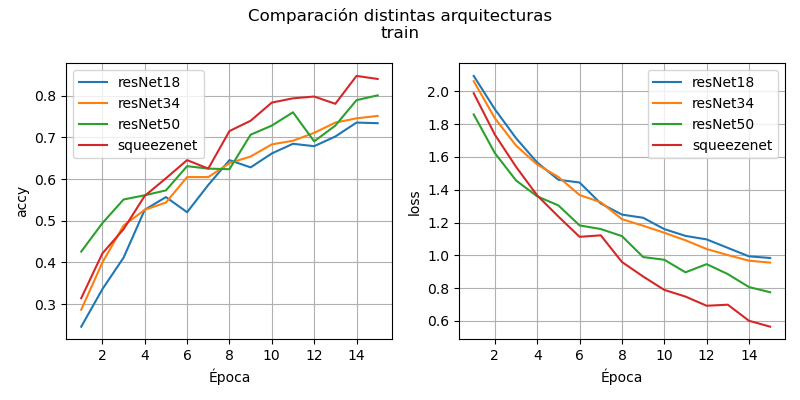

In [4]:
plot("train", "modelos", "Comparación distintas arquitecturas")

<IPython.core.display.Javascript object>


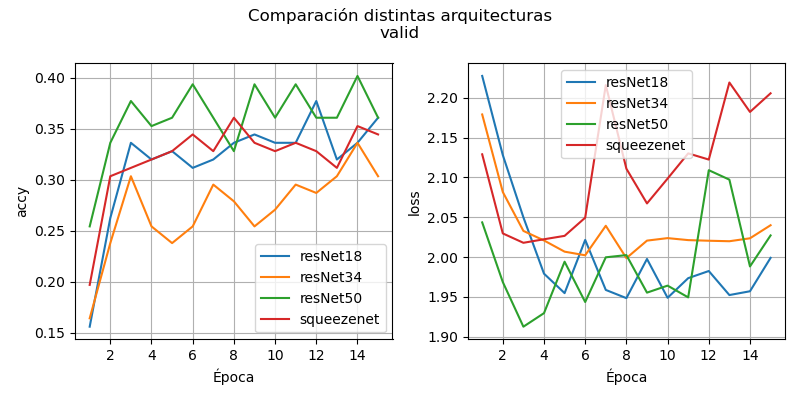

In [5]:
plot("valid", "modelos", "Comparación distintas arquitecturas")

Sin hacer cambios a los modelos pre-entrenados observamos que `resNet50` tiene el mejor desempeño en validación, tanto en accuracy como en loss. Vemos que `squeezenet` se sobreajusta rápidamente a los datos con un buen rendimiento en entrenamiento pero con una loss de validación que empieza a aumentar tras unas pocas épocas. De las tres versiones de resNet, `resNet34` nos entrega los peores resultados en validación.

Debido a lo observado, seleccionamos `resNet50` para entrenar nuestro modelo final.

### Rendimiento de ResNet50 con con distintas capas descongeladas?

Para poder complejizar nuestro modelo determinaremos el numero de capas las cuales nos otoguen un mejor rendimiento en loss como en accuracy. Para esto realizaremos pruebas descongelando `las ultimas?` 15, 22 y 30 capas convolucionales de ResNet50

<IPython.core.display.Javascript object>


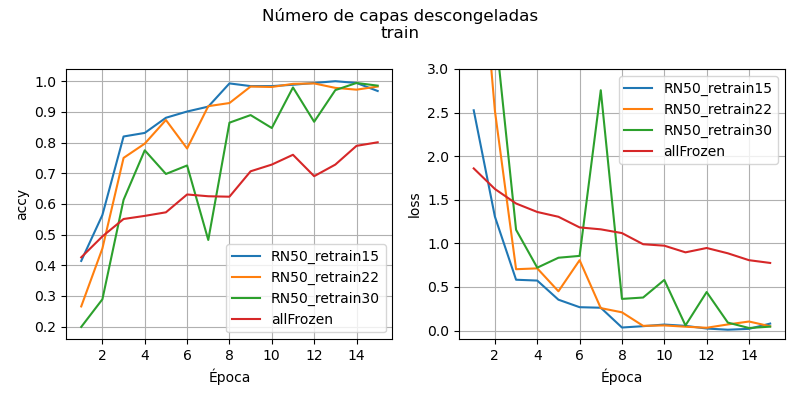

In [7]:
plot("train", "capas", "Número de capas descongeladas")

<IPython.core.display.Javascript object>


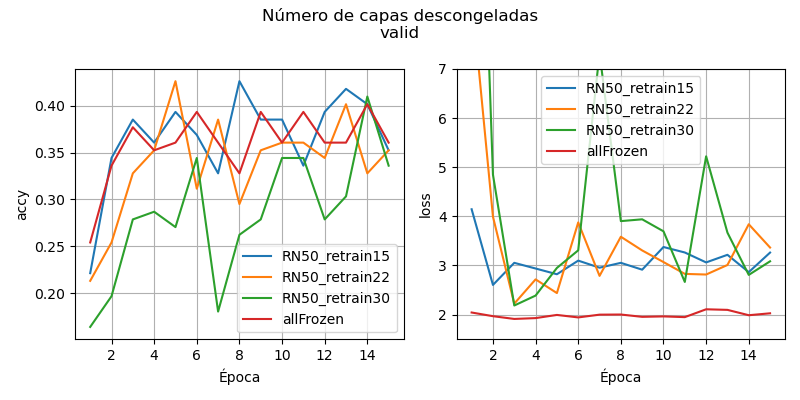

In [8]:
plot("valid", "capas", "Número de capas descongeladas")

 Al descongelar cierto número de capas convolucionales de resNet50 notamos que los modelos se sobreajustan rápidamente a nuestros datos. Optamos por trabajar descongelando las últimas 15 capas para tener un modelo un poco más complejo, para que pueda aprender filtros relacionados con features específicas de las piezas de arte, con un rendimiento potencial mayor al momento de utilizarlo en el conjunto de prueba. 
 
 Cabe destacar que los modelos asi como estan tienden a sobrejustar, por lo que intentaremos incorporar medidas para enfrentarlo e intentar disminuir la loss y mejorar el accuracy.

# sobreajuste

<IPython.core.display.Javascript object>


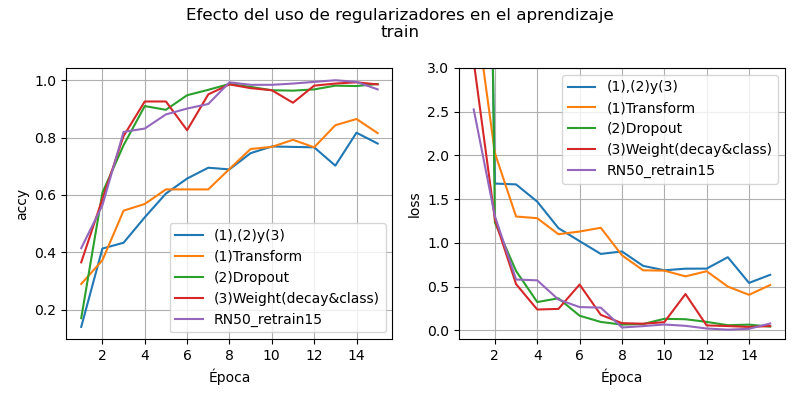

In [9]:
plot("train", "sobreajuste", "Efecto del uso de regularizadores en el aprendizaje")

<IPython.core.display.Javascript object>


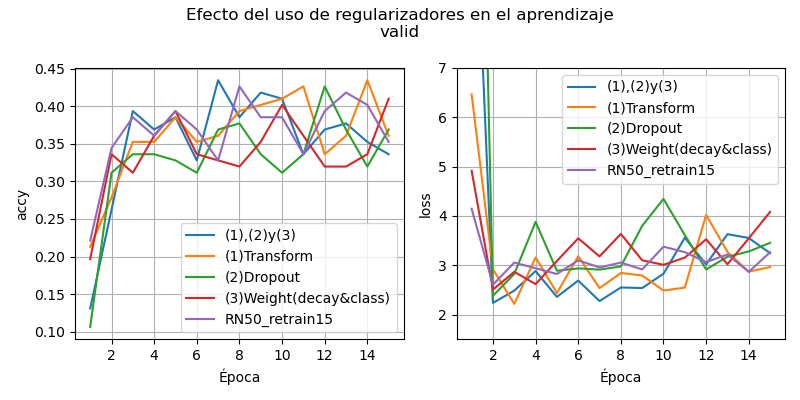

In [10]:
plot("valid", "sobreajuste", "Efecto del uso de regularizadores en el aprendizaje")

# seleccion de optimizador

<IPython.core.display.Javascript object>


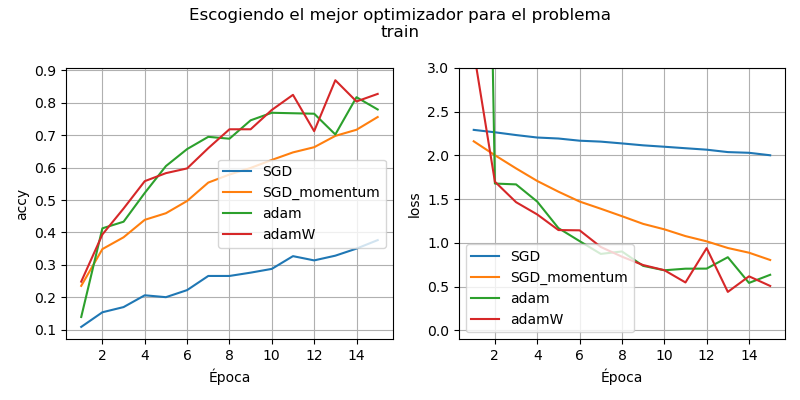

In [11]:
plot("train", "optimizadores", "Escogiendo el mejor optimizador para el problema")

<IPython.core.display.Javascript object>


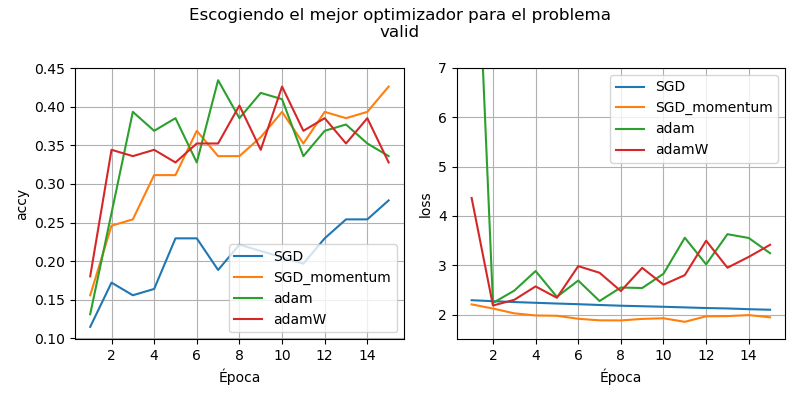

In [12]:
plot("valid", "optimizadores", "Escogiendo el mejor optimizador para el problema")

# Impacto del Learning Rate 

Hasta el momento, hemos realizado todos los experimentos con una tasa de aprendizaje fija de `1e-3`, pero si quieremos continuar mejorando, es necesario estudiar cómo se comporta nuestro modelo al utilizar otros valores. Para esto, incrementaremos el número de épocas a 25 para ver las curvas de aprendizaje resultantes al entrenar por más tiempo, y para no descartar una tasa de aprendizaje un poco más baja que pueda generar mejores resultados a largo plazo. 

<IPython.core.display.Javascript object>


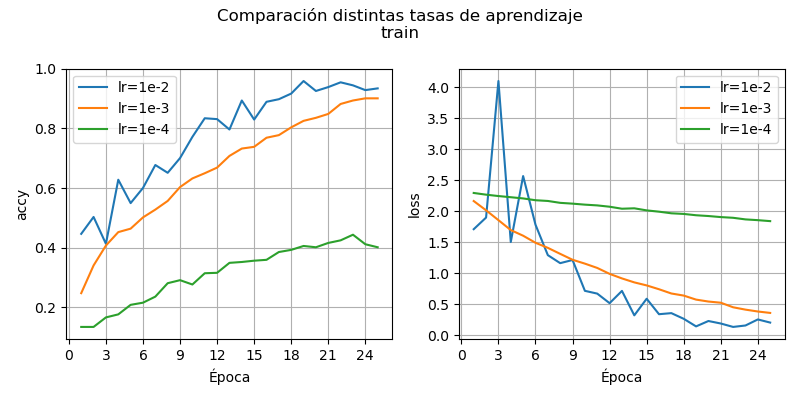

In [13]:
plot("train", "lr1", title="Comparación distintas tasas de aprendizaje")

Como era de esperarse, una tasa de aprendizaje más alta converge más rápido a una solución en la etapa de entrenamiento, pero lo hace de forma más irregular que las tasas más bajas. Podemos ver que `lr = 1e-2` se aprende el conjunto de entrenamiento con mayor facilidad que las otras dos tasas, alcanzando mejor accuracy y loss en las 25 épocas. Por el contrario, `lr = 1e-4` es demasiado baja para nuestro problema o configuración actual, llegando apenas a 40% de accuracy en entrenamiento en la totalidad de las épocas. La tasa `lr = 1e-3` que hemos utilizado hasta el momento se comporta con bastante estabilidad, pero nos interesa encontrar una aún mejor.

<IPython.core.display.Javascript object>


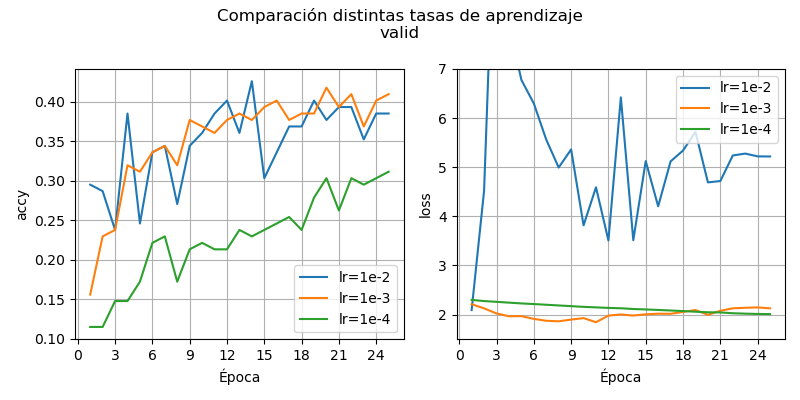

In [14]:
plot("valid", "lr1", title="Comparación distintas tasas de aprendizaje")

En validación ocurre algo similar a la etapa de entrenamiento, `lr = 1e-2` es muy irregular en accuracy y loss, pero con un resultado comparable al de `lr = 1e-3` en la primera métrica. Su loss, en cambio, nunca baja al nivel de las otras dos tasas de aprendizaje. Se observa que la tasa menor `lr = 1e-4` mejora constantemente en ambas métricas a medida que avanza en las épocas, pero lo hace de una forma muy lenta para nuestras necesidades.

## Tasa de aprendizaje fija y con decaimiento

```python
lr=1e-2
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
```

Reducir la tasa de aprendizaje en un factor factor de 10 cada 5 épocas.

https://pytorch.org/ignite/_modules/ignite/contrib/handlers/param_scheduler.html
```python

scheduler = CosineAnnealingScheduler(optimizer,
                                     "lr",
                                     start_value=lr,
                                     end_value=1e-4,
                                     cycle_size=len(train_loader))
```
Reduce la tasa de aprendizaje de 'start_value' a 'end_value' en cada ciclo. Al fijar el 'cycle_size' como el largo del train_loader, cada ciclo corresponde a una época.
El annealing toma la forma de la primera mitad del coseno.

Incorporamos también un valor intermedio a los utilizados anteriormente: `lr = 5e-3`

<IPython.core.display.Javascript object>


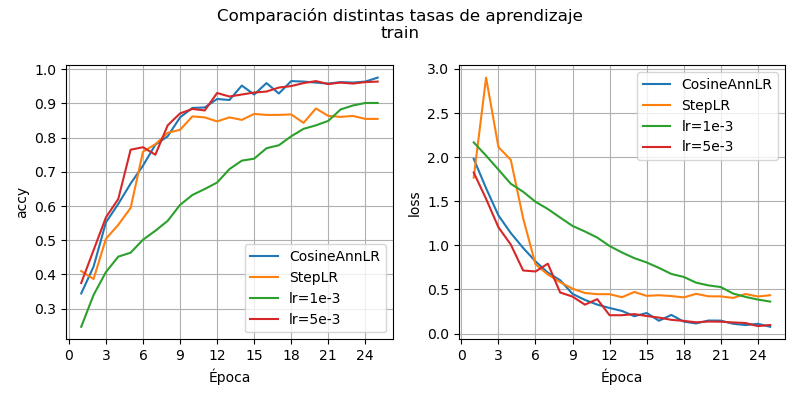

In [16]:
plot("train", "lr2", title="Comparación distintas tasas de aprendizaje")

<IPython.core.display.Javascript object>


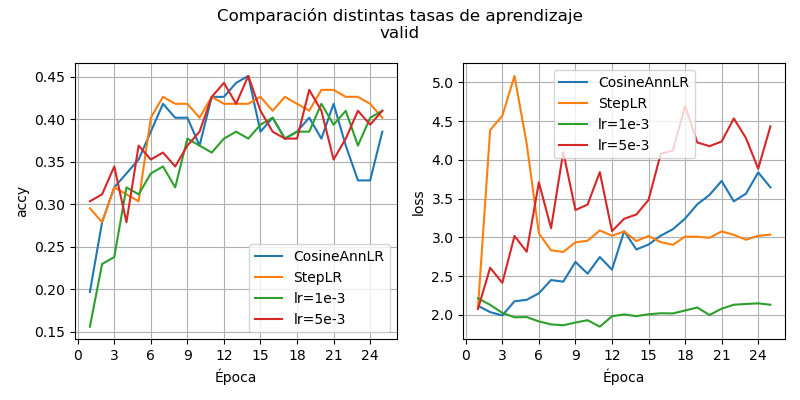

In [17]:
plot("valid", "lr2", title="Comparación distintas tasas de aprendizaje")

En entrenamiento, StepLR y `lr = 5e-3` se comportaron de forma similar con mejores accuracy y loss que `lr = 1e-3`. En la etapa de validación, `lr = 5e-3` logró lo que hasta el momento es nuestra mejor accuracy en esta etapa, alcanzando un 45%. `StepLR` comienza de forma irregular al partir con una tasa de aprendizaje más alta, pero en las épocas mas tardías, se estabiliza en una accuracy cercana a 42% y una loss que se ubica entre `lr = 5e-3` y `lr = 1e-3`.

En el caso de `CosineAnnealing`, los resultados son similares a `lr = 5e-3` en ambas etapas. En validación, también alcanza un 45% de accuracy con una loss ligeramente mejor. Todo esto con curvas bastante mas suaves.

 Posibles modelos finales: 
  - cosineAnn 15 epocas (acc)
  - steplr 20 epocas (loss)

Cabe destacar que las modificaciones que hicimos al modelo base, como incorporación de medidas contra el sobreajuste y el uso de schedulers, incorporan hiperparámetros adicionales (weight_decay, droput_rate, min/max lr, step, etc) cuyo ajuste mas preciso podría mejorar el rendimiento de nuestro modelo. Los valores que utilizamos, en gran parte, fueron seleccionados tras experimentar con estos y observar las curvas de aprendizaje, sin tener en cuenta todas las combinaciones posibles que surgen debido a las limitaciones de tiempo/capacidad de cómputo como para realizar un barrido más extensivo de valores.